## Imports e Dados

In [1]:
import pandas as pd
import statistics
import plotly.graph_objects as go
import warnings
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
import numpy as np
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.2f}'.format

In [2]:
# Definindo a paleta de cores
AZUL1, AZUL2, AZUL3, AZUL4, AZUL5 = '#03045e', '#0077b6', "#00b4d8", '#90e0ef', '#CDDBF3'
CINZA1, CINZA2, CINZA3, CINZA4, CINZA5 = '#212529', '#495057', '#adb5bd', '#dee2e6', '#f8f9fa'
VERMELHO1, LARANJA1, AMARELO1, VERDE1, VERDE2, VERDE3 = '#e76f51', '#f4a261',	'#e9c46a', '#4c956c', '#2a9d8f', '#264653'

In [3]:
dados = pd.read_parquet("Dados Comercializacao.parquet")

In [6]:
dados = dados.query("DATA >= '2024-07-15'")
dados.head()

,DATA,NOME,PRODUTO,VOLUME,DIA DA SEMANA,MES,TIPO
9978,2024-07-15,5501017-MS COMERCIO DE FRUTAS LT,03303-UVAS FINAS DE MESA,920.00,Segunda-feira,Jul,ATACADISTA
9979,2024-07-15,5500005-COMERCIO DE FRUTAS DANIE,03303-UVAS FINAS DE MESA,560.00,Segunda-feira,Jul,ATACADISTA
9980,2024-07-15,COMERCIO DE HORTIFRUTI BR,01403-LARANJA LIMA (CEU),360.00,Segunda-feira,Jul,ATACADISTA
9981,2024-07-15,COMERCIO DE HORTIFRUTI BR,01406-LARANJA SUCO,900.00,Segunda-feira,Jul,ATACADISTA
9982,2024-07-15,COMERCIO DE HORTIFRUTI BR,01401-LARANJA BAIA (UMBIGO),540.00,Segunda-feira,Jul,ATACADISTA


### Gráfico de barras empilhadas => Proporção de Atacadistas e GNP
Demonstrar através do gráfico em cada dia da semana o volume comercializado médio em cada dia sendo duas colunas, uma de valores absolutos e outra de valores em percentuais

In [7]:
ordem = ["Segunda-feira", "Terça-feira", "Quarta-feira", "Quinta-feira", "Sexta-feira"]
vol_dia_semana = dados.copy(deep=True)
vol_dia_semana = vol_dia_semana.groupby(['DIA DA SEMANA','TIPO'])['VOLUME'].mean()
vol_dia_semana = vol_dia_semana.reset_index()
vol_dia_semana = vol_dia_semana.pivot_table(index='DIA DA SEMANA', columns='TIPO', values='VOLUME')
vol_dia_semana = pd.DataFrame(vol_dia_semana, index=ordem)
vol_dia_semana.reset_index(inplace=True)

cores = [AZUL2, VERDE1]

In [8]:
def grafico_volume_dia_semana_tipo():
    # Definindo as cores do gráfico
    cores = [CINZA2, VERDE1]

    # Gerando o gráfico de colunas empilhadas 
    fig, ax = plt.subplots(figsize=(13, 6))
    ax = vol_dia_semana.plot(kind='bar', stacked=True, ax=ax, color=cores)

    # Personalizando o gráfico
    ax.set_title('Volume Médio da Carga em Kg \n Atacadistas e Produtores\n por dia da Semana', loc='left', fontsize=18, color=CINZA1)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_yticklabels([])
    ax.set_xticklabels(ordem)
    ax.xaxis.set_tick_params(labelsize=14, labelcolor=CINZA2, rotation=0)
    ax.set_frame_on(False)
    ax.grid(False)

    # remover todos os ticks do eixo x e y
    ax.tick_params(axis='both', which='both', length=0)

    # Add values inside each bar
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_x(), p.get_y()
        ax.text(x + width / 2, y + height / 2, f'{height:.1f}',
                ha='center', va='center', color='white', fontsize=12)

    return fig

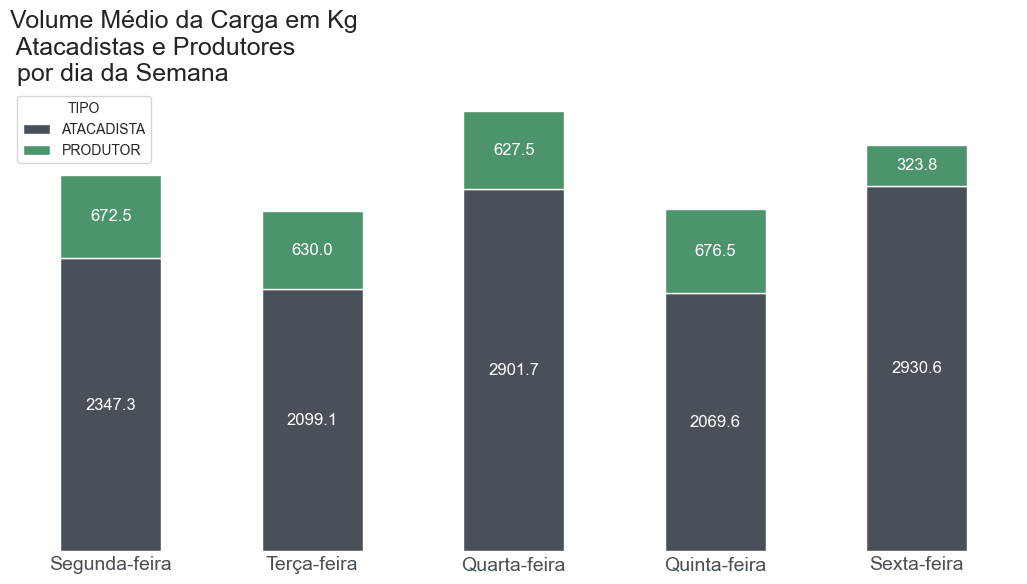

In [20]:
fig = grafico_volume_dia_semana_tipo()
fig.savefig('Média da Carga por dia da semana Atacadistas e Produtores.png', dpi=300, bbox_inches='tight')

In [21]:
print(f"Média atacadistas: {vol_dia_semana['ATACADISTA'].mean()}")
print(f"Média produtores: {vol_dia_semana['PRODUTOR'].mean()}")

Média atacadistas: 2469.657159453102
Média produtores: 586.0733467466212


Ranking 10 principais produtos e a Participação de Atacadistas e Produtores

In [22]:
lista_produtos = dados.groupby(['PRODUTO'])['VOLUME'].sum()
lista_produtos = lista_produtos.reset_index()
lista_produtos = lista_produtos.sort_values(by=['VOLUME'], ascending=False)
lista_produtos = lista_produtos[:10]['PRODUTO'].to_list()

In [23]:
# Criando um df com os dados desejados
df_envio = dados.copy(deep=True)
df_envio = df_envio.groupby(['PRODUTO','TIPO'])['VOLUME'].sum()
df_envio = df_envio.reset_index()
df_envio = df_envio[df_envio['PRODUTO'].isin(lista_produtos)]
df_envio['PRODUTO'] = df_envio['PRODUTO'].apply(lambda x: str(x[6:]).title())
df_envio = df_envio.sort_values(by='VOLUME', ascending=False)
df_envio = df_envio.pivot_table(index='PRODUTO', columns='TIPO', values='VOLUME')
df_envio = df_envio.fillna(0)
df_envio = df_envio.sort_values(by=['ATACADISTA', 'PRODUTO'], ascending=[True, False])
df_envio

TIPO,ATACADISTA,PRODUTOR
PRODUTO,,
Cenoura,338556.00,667970.00
Batata-Doce,595744.00,975830.00
Banana Prata / Branca,622185.00,517745.00
Banana Caturra / Nanica,819375.00,432518.00
Tomate Italiano / Paulista,976970.00,23540.00
Laranja Suco,988468.00,135570.00
Cebola Nacional,1093120.00,30080.00
Mamao Formosa,1295385.00,0.00
Batata Inglesa,2391705.00,55350.00


In [24]:
# Criando uma tabela cruzada (crosstab) com os modos de envio divididos pelos clientes B2C e B2B nomarlizado
df_envio_normalizado = df_envio.copy(deep=True)
df_envio_normalizado['SOMA'] = df_envio_normalizado['ATACADISTA'] + df_envio_normalizado['PRODUTOR']
df_envio_normalizado['ATACADISTA'] = (df_envio_normalizado['ATACADISTA'] / df_envio_normalizado['SOMA'])
df_envio_normalizado['PRODUTOR'] =  (df_envio_normalizado['PRODUTOR'] / df_envio_normalizado['SOMA'])
df_envio_normalizado = df_envio_normalizado.drop('SOMA', axis=1)
df_envio_normalizado

TIPO,ATACADISTA,PRODUTOR
PRODUTO,,
Cenoura,0.34,0.66
Batata-Doce,0.38,0.62
Banana Prata / Branca,0.55,0.45
Banana Caturra / Nanica,0.65,0.35
Tomate Italiano / Paulista,0.98,0.02
Laranja Suco,0.88,0.12
Cebola Nacional,0.97,0.03
Mamao Formosa,1.00,0.00
Batata Inglesa,0.98,0.02


In [25]:
# Função para escrita de texto utilizando diferentes cores. Não existe uma 
# função nativa para isso. (Adaptado de https://github.com/empathy87/storytelling-with-data)
from matplotlib import transforms

def texto_colorido(x, y, texto, cores, esp=30, ax=None, **kw):
    cores = list(reversed(cores))
    t = ax.transData
    canvas = ax.figure.canvas

    for i, linha in enumerate(reversed(texto.split('\n'))):
        frases = linha.split('||')
        for s, cor in zip(frases, cores[i]):
            texto = ax.text(x, y, s, color=cor, transform=t, **kw)
            texto.draw(canvas.get_renderer())
            ex = texto.get_window_extent()
            t = transforms.offset_copy(texto._transform, x=ex.width,
                                       units='dots')

        t = transforms.offset_copy(ax.transData, x=0, y=(i + 1) * esp, units='dots')

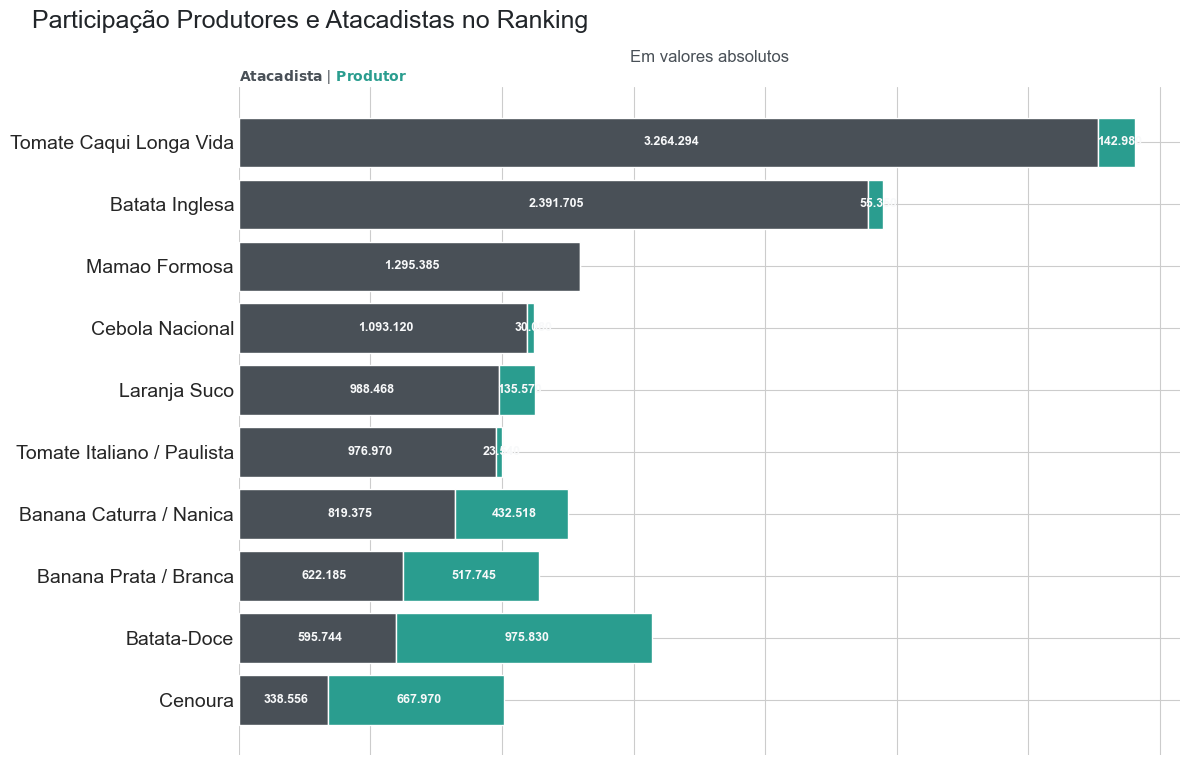

In [26]:
# Importando as bibliotecas
import matplotlib.pyplot as plt

# Área do gráfico e tema da visualização
fig, ax = plt.subplots(figsize=(12,8))

# Definindo as cores do gráfico
cores = [CINZA2, VERDE2]

# GRÁFICO 1 - Barras empilhadas
ax.barh(df_envio.index, df_envio["ATACADISTA"], color = cores[0])
ax.barh(df_envio.index, df_envio["PRODUTOR"], left = df_envio["ATACADISTA"], color = cores[1])
ax.set_title('Em valores absolutos\n', color = CINZA2)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels([])
ax.yaxis.set_tick_params(labelsize=14, color = CINZA2)
ax.set_frame_on(False)

# remover todos os ticks do eixo x e y
ax.tick_params(axis='both', which='both', length=0)

texto_colorido(0.1, 10, '$\\bf{Atacadista}$ | || $\\bf{Produtor}$', cores = [cores], ax=ax, fontsize=10) # legenda

fig.suptitle("Participação Produtores e Atacadistas no Ranking \n", fontsize=18, color=CINZA1, ha = 'right', x = 0.50, y = 0.95)

# Valores das barras
for container in ax.containers:
    labels = [f'{valor.get_width():,.0f}'.replace('.', '#').replace(',', '.').replace('#', ',') if valor.get_width() > 300 else '' for valor in container]
    ax.bar_label(container, label_type='center', labels=labels, size=9, color=CINZA5, fontweight='bold', padding=2)

fig.tight_layout()
# fig.show()
fig.savefig('Participação Produtores e Atacadistas no Ranking valores Absolutos.png')

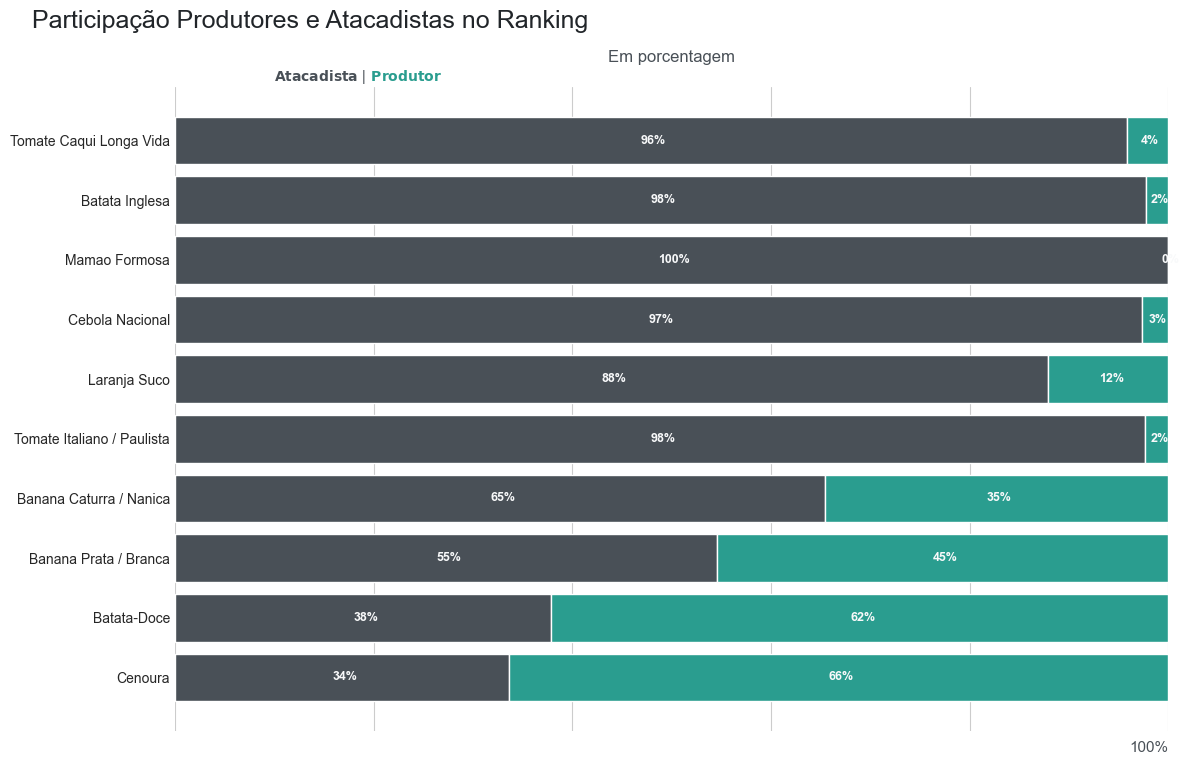

In [27]:
# Importando as bibliotecas
import matplotlib.pyplot as plt

# Área do gráfico e tema da visualização
fig, ax = plt.subplots(figsize=(12,8))

# Definindo as cores do gráfico
cores = [CINZA2, VERDE2]

# GRÁFICO 2 - Barras empilhadas 100 %
ax.barh(df_envio_normalizado.index, df_envio_normalizado["ATACADISTA"], color = cores[0])
ax.barh(df_envio_normalizado.index, df_envio_normalizado["PRODUTOR"], left = df_envio_normalizado["ATACADISTA"], color = cores[1])
ax.set_title('Em porcentagem\n', color = CINZA2)
ax.set_xlabel('100%', color = CINZA2, size = 11, loc='right')
ax.set_ylabel('')
ax.set_xticklabels([])
ax.set_frame_on(False)

# remover todos os ticks do eixo x e y
ax.tick_params(axis='both', which='both', length=0)

texto_colorido(0.1, 10, '$\\bf{Atacadista}$ | || $\\bf{Produtor}$', cores = [cores], ax=ax, fontsize=10) # legenda
fig.suptitle("Participação Produtores e Atacadistas no Ranking \n", fontsize=18, color=CINZA1, ha = 'right', x = 0.50, y = 0.95)

# Valores das barras
for container in ax.containers:
    labels = [f'{valor.get_width()*100:.0f}%' for valor in container]
    ax.bar_label(container, label_type='center', labels=labels, size=9, color=CINZA5, fontweight='bold', padding=2)

fig.tight_layout()
# fig.show()
fig.savefig('Participação Produtores e Atacadistas no Ranking valores Percentuais.png')

In [28]:
volume_comercializado_dia = {
    "DATA":['2024-06-17','2024-06-18','2024-06-19','2024-06-20','2024-06-21','2024-06-24','2024-06-25','2024-06-26','2024-06-27','2024-06-28','2024-06-17','2024-06-18','2024-06-19','2024-06-20','2024-06-21','2024-06-24','2024-06-25','2024-06-26','2024-06-27','2024-06-28'],
    "VOLUME":[355.9, 474.9, 174.4, 602.2, 101.5, 475.5, 623.2, 96.3, 822.5, 114,1891.7,871,657.1,1170.6,427.6,1998,1068.5,619,1264,481],
    "TIPO":['PRODUTOR'] * 10 + ['ATACADISTA'] * 10
}
volume_comercializado_dia = pd.DataFrame.from_dict(volume_comercializado_dia)
volume_comercializado_dia = volume_comercializado_dia.reset_index()
volume_comercializado_dia['DATA'] = volume_comercializado_dia['DATA'].astype('datetime64[ns]')
volume_comercializado_dia

,index,DATA,VOLUME,TIPO
0,0,2024-06-17,355.90,PRODUTOR
1,1,2024-06-18,474.90,PRODUTOR
2,2,2024-06-19,174.40,PRODUTOR
3,3,2024-06-20,602.20,PRODUTOR
4,4,2024-06-21,101.50,PRODUTOR
5,5,2024-06-24,475.50,PRODUTOR
6,6,2024-06-25,623.20,PRODUTOR
7,7,2024-06-26,96.30,PRODUTOR
8,8,2024-06-27,822.50,PRODUTOR
9,9,2024-06-28,114.00,PRODUTOR


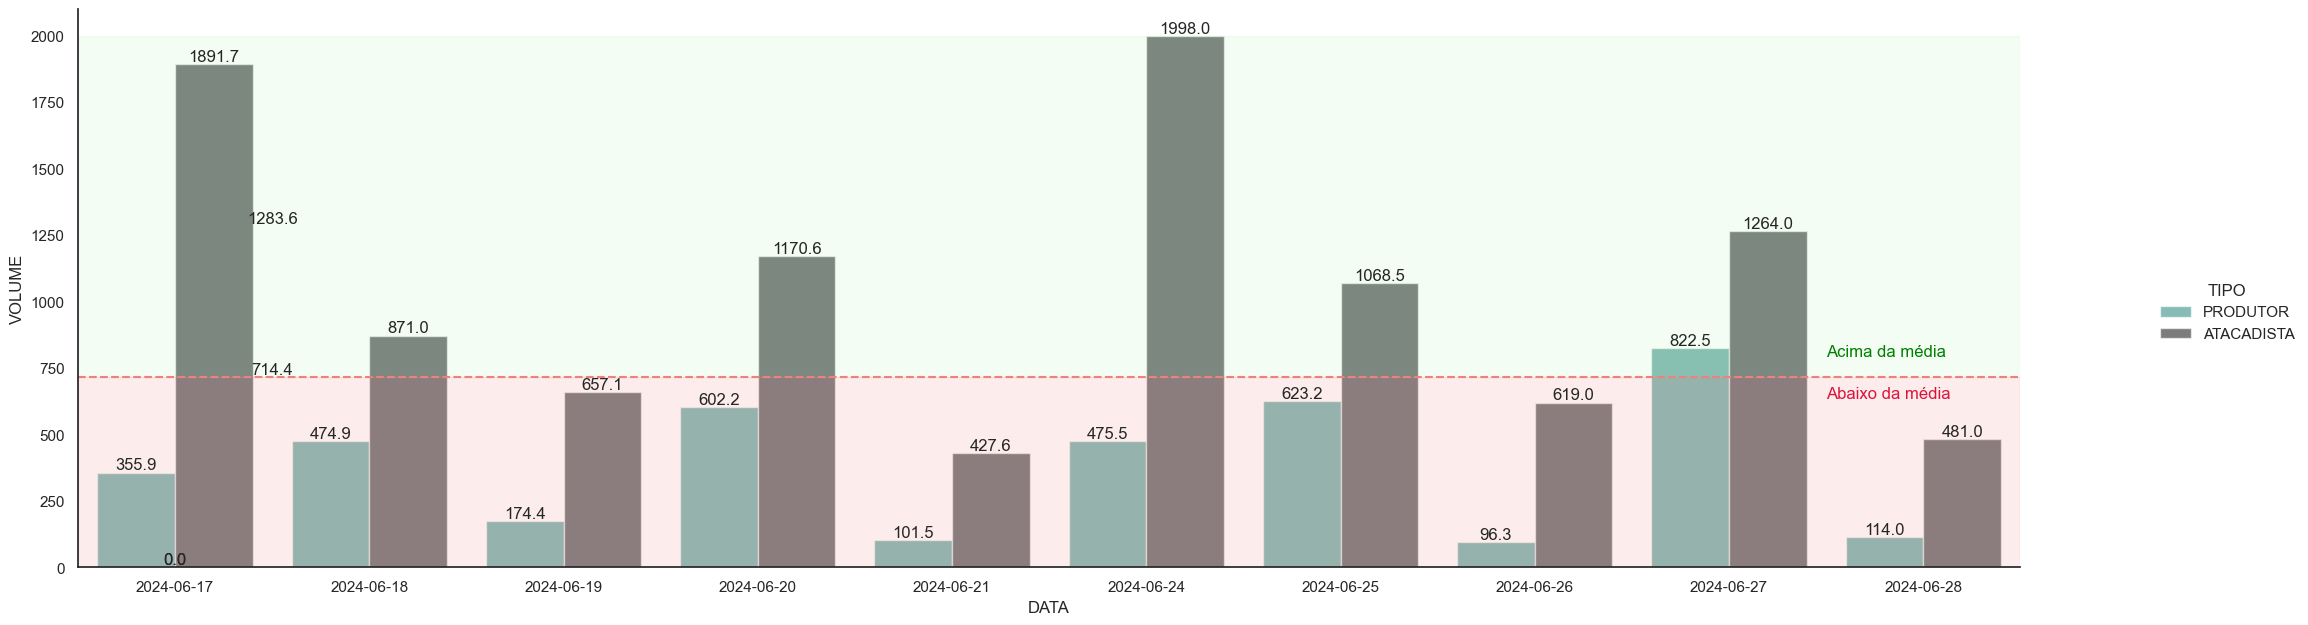

In [30]:
sns.set_theme(style="white")
graph = sns.catplot(data=volume_comercializado_dia, x="DATA",y='VOLUME', hue="TIPO", kind="bar", palette= [VERDE2, CINZA1], alpha=.6, height=12)
plt.gcf().set_size_inches(24, 6)

plt.axhline(y=volume_comercializado_dia["VOLUME"].mean(), color="lightcoral", linestyle="--", label="Média")
plt.axhspan(volume_comercializado_dia["VOLUME"].mean(), volume_comercializado_dia["VOLUME"].max(), color="lightgreen",alpha=0.1)
plt.axhspan(0,volume_comercializado_dia["VOLUME"].mean(),  color="lightcoral",alpha=0.15)
plt.text(8.5,volume_comercializado_dia["VOLUME"].mean() + 80, "Acima da média", color="Green")
plt.text(8.5,volume_comercializado_dia["VOLUME"].mean() - 80, "Abaixo da média", color="crimson")

for ax in graph.axes.flat:
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.1f}", (p.get_x() + p.get_width() / 2., p.get_height()), ha="center", va="bottom")


plt.show()
# plt.savefig("Volume diário Comercializado de Produtos e Atacadistas.png")

## COTAÇÃO
<hr>

In [17]:
caminho_cotacao = (r"C:\Users\marci\OneDrive\CEASA\Anchieta\Comparativo\Comparativo.xlsm")
dados_cotacoes = pd.read_excel(caminho_cotacao, sheet_name='dados_comparativo')
dados_cotacoes['UNIDADE'] = dados_cotacoes['UNIDADE'].apply(lambda x: 'Und' if x == 'Pé' or x == 'Cabeça' else x)
dados_cotacoes['DATA'] = dados_cotacoes['DATA'].dt.strftime('%d')
dados_cotacoes

,DATA,PRODUTO,UNIDADE,PRECO
0,03,00101-ABACATE,kg,3.60
1,03,00202-ABACAXI PEROLA,Und,7.00
2,03,00501-BANANA CATURRA / NANICA,Kg,2.50
3,03,00503-BANANA PRATA / BRANCA,Kg,3.25
4,03,01406-LARANJA SUCO,kg,3.25
...,...,...,...,...
735,28,08102-CENOURA,Kg,5.25
736,28,08501-MANDIOCA,kg,2.00
737,28,08901-OVO BRANCO CX30DZ,Dz,6.00
738,28,03201-TANGERINA COMUM / CAI,NaN,2.50


In [18]:
produto01 = dados_cotacoes.loc[dados_cotacoes['PRODUTO'] == '07402-TOMATE ITALIANO / PAULISTA']
produto01['PRODUTO'] = produto01['PRODUTO'].apply(lambda x: str(x[6:]).title())

produto02 = dados_cotacoes.loc[dados_cotacoes['PRODUTO'] == '08001-CEBOLA NACIONAL']
produto02['PRODUTO'] = produto02['PRODUTO'].apply(lambda x: str(x[6:]).title())

produto03 = dados_cotacoes.loc[dados_cotacoes['PRODUTO'] == '00503-BANANA PRATA / BRANCA']
produto03['PRODUTO'] = produto03['PRODUTO'].apply(lambda x: str(x[6:]).title())

produto04 = dados_cotacoes.loc[dados_cotacoes['PRODUTO'] == '03201-TANGERINA COMUM / CAI']
produto04['PRODUTO'] = produto04['PRODUTO'].apply(lambda x: str(x[6:]).title())

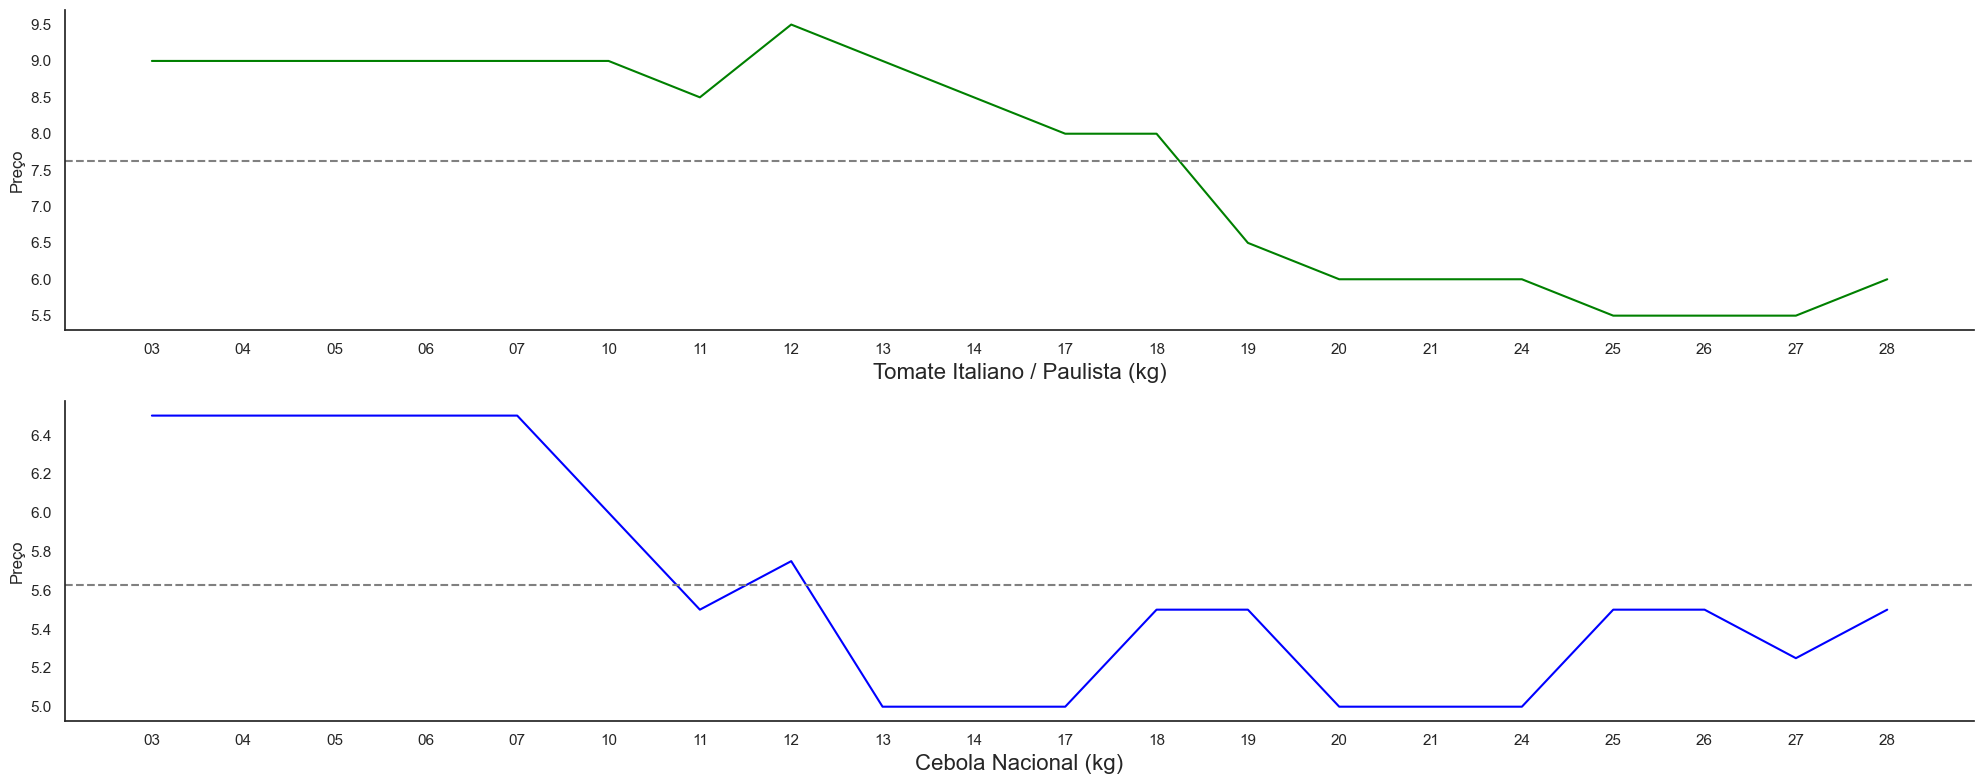

In [19]:
# Crie os subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 8))

# Gráfico 1
axs[0,0] = sns.lineplot(data=produto01, x='DATA', y='PRECO', ax=axs[0,0], color="green")
axs[0,0].set_ylabel("Preço")
axs[0,0].set_xlabel(f"{produto01['PRODUTO'].iloc[0]} ({produto01['UNIDADE'].iloc[0]})", fontsize=16)
axs[0,0].grid(False)
axs[0,0].axhline(y=produto01['PRECO'].mean(), color='gray', linestyle='--', label='Média')


# Gráfico 2
axs[0,1] = sns.lineplot(data=produto02, x='DATA', y='PRECO', ax=axs[0,1], color="blue")
axs[0,1].set_ylabel("Preço")
axs[0,1].set_xlabel(f"{produto02['PRODUTO'].iloc[0]} ({produto02['UNIDADE'].iloc[0]})", fontsize=16)
axs[0,1].grid(False)
axs[0,1].axhline(y=produto02['PRECO'].mean(), color='gray', linestyle='--', label='Média')
# 
# Gráfico 3
axs[1, 0] = sns.lineplot(data=produto03, x='DATA', y='PRECO', ax=axs[1, 0], color="crimson")
axs[1, 0].set_ylabel("Preço")
axs[1, 0].set_xlabel(f"{produto03['PRODUTO'].iloc[0]} ({produto03['UNIDADE'].iloc[0]})", fontsize=16)
axs[1, 0].grid(False)
axs[1, 0].axhline(y=produto03['PRECO'].mean(), color='gray', linestyle='--', label='Média')

# Gráfico 4
axs[1, 1] = sns.lineplot(data=produto04, x='DATA', y='PRECO', ax=axs[1, 1], color="darkorange")
axs[1, 1].set_ylabel("Preço")
axs[1, 1].set_xlabel(f"{produto04['PRODUTO'].iloc[0]} ({produto04['UNIDADE'].iloc[0]})", fontsize=16)
axs[1, 1].grid(False)
axs[1, 1].axhline(y=produto04['PRECO'].mean(), color='gray', linestyle='--', label='Média')

# Remova as bordas desnecessárias
sns.despine()

# Ajuste o layout
fig.tight_layout()

# Salve o gráfico
fig.savefig("Cotação_produtos_selecionados 3.png")

# Mostre o gráfico
# plt.show()

In [20]:
print(f"Média {produto01['PRODUTO'].iloc[0]}: R$ {round(produto01['PRECO'].mean(),2)}")
print(f"Média {produto02['PRODUTO'].iloc[0]}: R$ {round(produto02['PRECO'].mean(),2)}")
print(f"Média {produto03['PRODUTO'].iloc[0]}: R$ {round(produto03['PRECO'].mean(),2)}")
print(f"Média {produto04['PRODUTO'].iloc[0]}: R$ {round(produto04['PRECO'].mean(),2)}")

Média Tomate Italiano / Paulista: R$ 7.62
Média Cebola Nacional: R$ 5.62


NameError: name 'produto03' is not defined

Média Tomate Caqui Longa Vida: R$ 7.93
Média Batata Inglesa: R$ 6.93
Média Banana Caturra / Nanica: R$ 2.12
Média Mamao Formosa: R$ 5.95
Média Batata-Doce: R$ 2.76
Média Laranja Suco: R$ 2.81
Média Banana Prata / Branca: R$ 2.86
Média Tangerina Comum / Cai: R$ 2.11


In [ ]:
cotacao_selecionados = dados_cotacoes.copy(deep=True)
cotacao_selecionados = cotacao_selecionados.loc[cotacao_selecionados['PRODUTO'].isin(lista_produtos)]
cotacao_selecionados.to_excel("medias produtos.xlsx")

## Contagem de Produtores Presentes
<hr>

In [21]:
produtores = {
    "Dia": [17,18,19,20,21,24,25,26,27,28],
    "Nº de Produtores": [201, 299, 84,385,124,187,280,68,345,88]
}
numero_produtores = pd.DataFrame(produtores)

In [13]:
sns.set_theme(style="white")
graph = sns.catplot(data=numero_produtores, x="Dia", y="Nº de Produtores", kind="bar", alpha=.6, height=12)
plt.gcf().set_size_inches(18, 6)

mean_value = numero_produtores["Nº de Produtores"].mean()
plt.axhline(y=mean_value, color="lightcoral", linestyle="--", label="Média")

for ax in graph.axes.flat:
    for p in ax.patches:
        height = p.get_height()
        if height < mean_value:
            p.set_facecolor("darkred")  # below mean, set to light red
        else:
            p.set_facecolor(VERDE1)  # above mean, set to light green
        ax.annotate(f"{height:.1f}", (p.get_x() + p.get_width() / 2., height), ha="center", va="bottom")
plt.legend(loc="best")

plt.show()
# plt.savefig("Número de Produtores por dia.png")

NameError: name 'numero_produtores' is not defined

In [ ]:
semana01 = [201, 299, 84,385,124]
semana02 = [187,280,68,345,88]

# Calculate the mean using statistics.mean function
mean_semana01 = statistics.mean(semana01)
mean_semana02 = statistics.mean(semana02)

# Print the results
print(mean_semana01)
print(mean_semana02)
print(round(((mean_semana02 - mean_semana01) / mean_semana01)*100,1))